<a href="https://colab.research.google.com/github/ronaldolg26/Data_Science_Airbnb/blob/main/Drone_ecommerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Efeito dos drones no e-commerce em São Paulo.

---



<img src='https://github.com/ronaldolg26/Efeito_drones_saopaulo/blob/main/drone-ifood-foto-divulgacao-960x540.jpg?raw=true' >

Dês do início das civilizações, a troca de informações é algo em constate evolução. Na Pérsia antiga, por exemplo, surgiu o que pode ser considera o primeiro correio do mundo. Com centenas de estações espalhadas por todo o reinado, os mensageiros montados a cavalo iam de um lugar a outro levando mensagens. Na França, em meados de 1653, as distâncias de 250km eram percorridas em 2 dias. Além disso, a mais fascinante das formas de transmitir algo para alguém era pela utilização dos pombos-correios que chegavam a velocidade de 70km/h.

Hoje, os transportes de mercadorias são feitos atráves dos mais diversos meios de transporte. Navios, aviões, carros, motos, bicicletas e até patins entram na lista do modo de executar desse translado. Com o barateamento de novas tecnologias, um novo meio de transporte vem ganhado destaque nesse cenário pela sua eficiência e agilidade. Drones, são aeronaves não tripuladas de diversos tamanhos que inicialmente possuíam usos militares, mas que hoje em dia possuem uma variedade grande de utilizações, desde captação de imagens para eventos, transmissões de imagens para atividades jornalísticas, pulverização de agrotoxico em lavouras e, a mais nova utilização, entrega de comida pelo ifood.


##Cenário brasileiro

No começo do ano de 2022, a Agência Nacional de Aviação Civil (ANAC) autorizou o Ifood, em parceria com Speedbird Aero, a realizar entregas com aeronaves remotamente pilotadas (RPAs) em todo o território brasileiro. “Com ela, os drones estão liberados para realizar entregas com cargas de até 2,5 quilos em um raio de 3 quilômetros, inclusive em ambientes urbanos, mantendo margens de segurança estabelecidas no projeto. ” Todavia, a empresa Speedbird Aero possui outros modelos de maior alcance, dessa forma é possível vislumbrar em um futuro próximo esse meio de entrega atingindo outros segmentos além das foodtechs. 

Esse notebook se propõe em estimar os impactos que essa nova tecnologia causará no e-commerce brasileiro. Para essa análise utilizaremos os padrões velocidade, carga e distância dos modelos de drones da Speesbird Aero, bem como os dados do e-commerce de São Paulo das marketplaces que hospedam seus dados na Olist, empresa esta que gentilmente cedeu seus dados de forma pública no Kaggle. Obrigado Olist.




## Importando as bibliotecas

In [ ]:
#importando grafico de Waffle
!pip install pywaffle -q

     |████████████████████████████████| 565 kB 3.2 MB/s 


In [ ]:
!pip install haversine -q
from haversine import haversine

In [136]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pywaffle import Waffle
import time
from pandas._libs import index
import folium
from folium.plugins import HeatMap
import numpy as np
from numpy.ma.core import array
import datetime as dt
from datetime import time, timedelta
import seaborn as sns

## 1. Extração dos dados

In [ ]:
dados_do_cliente = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BANCO DE DADOS/E-comerce Brasil/olist_customers_dataset.csv')
geolocalizacao = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BANCO DE DADOS/E-comerce Brasil/olist_geolocation_dataset.csv')
itens_do_pedido = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BANCO DE DADOS/E-comerce Brasil/olist_order_items_dataset.csv')
dados_de_pagameto = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BANCO DE DADOS/E-comerce Brasil/olist_order_payments_dataset.csv')
reviews_de_pedidos = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BANCO DE DADOS/E-comerce Brasil/olist_order_reviews_dataset.csv')
dados_do_pedido = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BANCO DE DADOS/E-comerce Brasil/olist_orders_dataset.csv')
dados_de_produto = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BANCO DE DADOS/E-comerce Brasil/olist_products_dataset.csv')
dados_do_vendedor = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BANCO DE DADOS/E-comerce Brasil/olist_sellers_dataset.csv')
nome_da_categoria = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BANCO DE DADOS/E-comerce Brasil/product_category_name_translation.csv')

Para entender melhor a mesclagem dos dados, deixo um esquema dos conjuntos da função merge

<img src='https://www.datasciencemadesimple.com/wp-content/uploads/2017/09/join-or-merge-in-python-pandas-1.png?ezimgfmt=ng:webp/ngcb1'>

In [ ]:
# criando o Data frame
# analisando as colunas
# dados_do_pedido.keys()
# juntandos os Data Frame a dados_do_pedido
df = dados_do_pedido.merge(itens_do_pedido, on='order_id', how='left')
df = df.merge(dados_de_pagameto, on='order_id', how ='outer', validate = 'm:m')
df = df.merge(reviews_de_pedidos, on='order_id', how = 'outer')
df = df.merge(dados_de_produto, on='product_id', how='outer')
df = df.merge(dados_do_cliente,on='customer_id',how='outer')
df = df.merge(dados_do_vendedor, on='seller_id',how='outer') 

In [ ]:
# Selecioando apenas as vendas no estado de São Paulo
dfsp = df[df['customer_state'] == 'SP']
dfsp.head()
dfsp.shape

(50265, 39)

##2. Limpeza dos dados

In [ ]:
# Verificando a PORCENTAGEM de valores nulos por coluna e classiicando em ordem decrescente.
(dfsp.isnull().sum()/dfsp.shape[0]*100).sort_values(ascending=False) 

review_comment_title             87.866309
review_comment_message           59.536457
order_delivered_customer_date     2.892669
product_category_name             2.228191
product_name_lenght               2.228191
product_description_lenght        2.228191
product_photos_qty                2.228191
order_delivered_carrier_date      2.114792
product_width_cm                  0.803740
product_height_cm                 0.803740
product_weight_g                  0.803740
product_length_cm                 0.803740
freight_value                     0.795782
seller_state                      0.795782
price                             0.795782
seller_id                         0.795782
product_id                        0.795782
order_item_id                     0.795782
seller_zip_code_prefix            0.795782
seller_city                       0.795782
shipping_limit_date               0.795782
review_answer_timestamp           0.682383
review_score                      0.682383
review_crea

Analisando o percentual de dados ausentes, nota-se que o Tituto do Comentario e os Comentário tem uma ausência cignificativa, o que acaba gerando muitos valores nulos. Para eliminar os demais valores nulos que não sejam o titulo do comentário(```review_comment_title```) ou o cometário(```review_comment_message```)  é necessário substituir o valor dessas duas colunas por algum valor.  

Foi escolhido "No title" e "No message" para substituir os NaN.

In [ ]:
dfsp['review_comment_title'] = dfsp['review_comment_title'].fillna('No title')
dfsp['review_comment_message'] = dfsp['review_comment_message'].fillna('No message')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Agora podemos eliminar os valores nulos

In [ ]:
#Eiminção dos valores nulos(NaN)
dfsp_antes = dfsp.shape[0]
dfsp= dfsp.dropna()
dfsp_depois = dfsp.shape[0]
print('Quantidade de linhas ANTES da retirada dos valores nulos:', dfsp_antes)
print('Quantidade de linhas DEPOIS da retirada dos valores nulos:',dfsp_depois)
print(f'Foi eliminado um percetual de {(dfsp_antes-dfsp.shape[0])/dfsp_antes * 100:.3}% dos valores')

Quantidade de linhas ANTES da retirada dos valores nulos: 50265
Quantidade de linhas DEPOIS da retirada dos valores nulos: 47823
Foi eliminado um percetual de 4.86% dos valores


Atentemos agora para os tipos das variáveis. Vejam que inumeras datas estao no formato de string e por isso precisam ser convertidas. 

Para essa conversão utiliza-se a função to_datetime do ```pandas```

In [ ]:
# Convertendo variaveis de tempo
dfsp['order_purchase_timestamp'] = pd.to_datetime(dfsp.order_purchase_timestamp)
dfsp['order_approved_at'] = pd.to_datetime(dfsp.order_approved_at)
dfsp['order_delivered_carrier_date'] = pd.to_datetime(dfsp.order_delivered_carrier_date)
dfsp['order_delivered_customer_date'] = pd.to_datetime(dfsp.order_delivered_customer_date)
dfsp['order_estimated_delivery_date'] = pd.to_datetime(dfsp.order_estimated_delivery_date)
dfsp['shipping_limit_date'] = pd.to_datetime(dfsp.shipping_limit_date)
dfsp['review_creation_date'] = pd.to_datetime(dfsp.review_creation_date)

dfsp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47823 entries, 0 to 119142
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       47823 non-null  object        
 1   customer_id                    47823 non-null  object        
 2   order_status                   47823 non-null  object        
 3   order_purchase_timestamp       47823 non-null  datetime64[ns]
 4   order_approved_at              47823 non-null  datetime64[ns]
 5   order_delivered_carrier_date   47823 non-null  datetime64[ns]
 6   order_delivered_customer_date  47823 non-null  datetime64[ns]
 7   order_estimated_delivery_date  47823 non-null  datetime64[ns]
 8   order_item_id                  47823 non-null  float64       
 9   product_id                     47823 non-null  object        
 10  seller_id                      47823 non-null  object        
 11  shipping_limit

## 2.1 Outliers e Valores Inaplicáveis

Nas marketplaces do brasil são possiveis encotrar os mais diversos tipos de produtos, desde nave invisivel da Mulher Maravilha até a nuvem voadora do Goku.
<center><img  src="https://classic.exame.com/wp-content/uploads/2016/09/size_960_16_9_ml-nave-mm-2013-07-22.jpg?quality=70&strip=info&w=920" height='300' ></ceter> 

<center><img src="https://classic.exame.com/wp-content/uploads/2016/09/size_960_16_9_ml-nuvem-goku-2013-07-22.jpg?quality=70&strip=info&w=920" height
 ='300'> </center> 




Produtos como esses podem gerar otliers na analise. Logo, a busca e eliminção desses produtos melhorará a qualidade da nossa projeção. Além disso, o foco será retirar também aqueles valores que tornem inaplicáveis a utilização dos drones, como pesos e medidas que não são suportados por drones disponiveis no mercado.  


### Modelos de Drones

In [ ]:
#Caracteristicas dos drones
drone = {'modelo': ['DRARGO-1','DRARGO-2','DRARGO-3','DRARGO-4','DRARGO-5'], 
         'velocidade': [100,100,100,100,100], 
         'peso_suportado_g': [4100,3700,3400,3000,1700],
         'distancia_max_km': [100,200,300,400,700]
         }
drone = pd.DataFrame(drone).set_index('modelo')
drone

,velocidade,peso_suportado_g,distancia_max_km
modelo,,,
DRARGO-1,100,4100,100
DRARGO-2,100,3700,200
DRARGO-3,100,3400,300
DRARGO-4,100,3000,400
DRARGO-5,100,1700,700


Para fazer essa busca, a plotagem dos Histogramas é um bom passo.

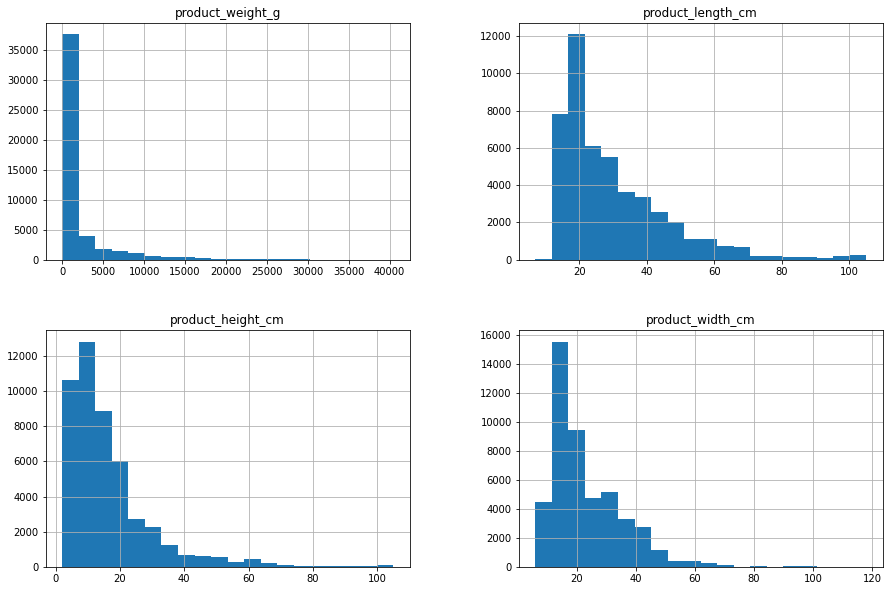

In [ ]:
dfsp[['product_weight_g','product_length_cm','product_height_cm','product_width_cm']].hist(bins=20,figsize=(15,10));

Percebe-se que o peso da maioria dos produtos estão entre os suportados pelos drones. Os valores que ultrapassarem as 8000g seram desconsiderados. Além disso, os produtos que tiverem dimensão superior a 80cm em qualquer uma das suas dimesões serao descartados pois existe a viabilidade das embalagens para transporte. 

In [ ]:
# Adequação aos padrões da analise
dfsp1= dfsp[(dfsp['product_height_cm'] <= 80) & (dfsp['product_length_cm']<= 80) & (dfsp['product_width_cm'] < 80) & (dfsp['product_weight_g']< 8000) ]

In [ ]:
# Porcentagem dos valores retirados
print(f"Para adequar aos padrões da analise foram retirados {(1-(dfsp1.shape[0]/dfsp_antes)) * 100 :.5} % dos dados. ")

Para adequar aos padrões da analise foram retirados 12.627 % dos dados. 


##3. Distância percorrida

Para criar uma projeção mais realista possível, é necessário calcular a distância que o drone terá que percorrer entre o vendedor e o cliente. Todavia, essa distância terá um erro que ainda não é possivel de ser calculado em virtude das chamadas aerovias, que são verdadeiras avenidas aéras onde os drones iram percorrer até a cidade de entrega dos produtos. Essas aerovias para drones respeitaram regras da ANAC como não sobrevoar areas urbanas ou em rota de outras aeronaves. De todo modo, acreditando que essas aerovias ligaram todos os municipios do estado de São Paulo, a distância será calculada com base no CEP dos muicipios entre vendedor e cliente. 

In [ ]:
geolocalizacao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


Para o CEP de determinadas cidades de São Paulo precisaremos de um "the jump of cat", já que várias cidades tem mais de um CEP. Para contornar esse problema, agruparemos os CEPs de uma mesma cidade através da média dos seus valores.

In [ ]:
# Selecionando os dados de geolacalização de São Paulo
geo_state_sp = geolocalizacao[geolocalizacao['geolocation_state']=='SP']
# Agrupando os CEP 
geo_state = geo_state_sp.groupby('geolocation_city')['geolocation_lat','geolocation_lng'].mean().reset_index()
geo_state

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


,geolocation_city,geolocation_lat,geolocation_lng
0,adamantina,-21.695743,-51.046362
1,adolfo,-21.234456,-49.642716
2,agisse,-23.537329,-48.544934
3,agua vermelha,-21.893562,-47.890985
4,aguai,-22.057066,-46.976182
...,...,...,...
1043,águas de são pedro,-22.603201,-47.870245
1044,álvares florence,-20.322727,-49.906896
1045,álvares machado,-22.079381,-51.470482
1046,álvaro de carvalho,-22.078904,-49.721423


In [ ]:
geo_customer = geo_state
geo_customer = geo_customer.rename(columns={'geolocation_city':'customer_city',
                                            'geolocation_lat': 'lat_customer',
                                            'geolocation_lng':'lon_customer'})
geo_customer.head()

,customer_city,lat_customer,lon_customer
0,adamantina,-21.695743,-51.046362
1,adolfo,-21.234456,-49.642716
2,agisse,-23.537329,-48.544934
3,agua vermelha,-21.893562,-47.890985
4,aguai,-22.057066,-46.976182


In [ ]:
geo_seller = geo_state
geo_seller = geo_seller.rename(columns={'geolocation_city':'seller_city',
                                        'geolocation_lat': 'lat_seller',
                                        'geolocation_lng':'lon_seller'})
geo_seller.head()

,seller_city,lat_seller,lon_seller
0,adamantina,-21.695743,-51.046362
1,adolfo,-21.234456,-49.642716
2,agisse,-23.537329,-48.544934
3,agua vermelha,-21.893562,-47.890985
4,aguai,-22.057066,-46.976182


In [ ]:
dfsp1 = dfsp.merge(geo_customer, how='left', on='customer_city')

In [ ]:
new_dfsp = dfsp1.merge(geo_seller, how='left', on='seller_city')

In [ ]:
from folium.map import Icon
latitude = geo_state['geolocation_lat'].values
longitude = geo_state['geolocation_lng'].values
#nomes = geo_state['geolocation_city'].apply(lambda x : x.lower()).values
# Criando o Mapa
mapa = folium.Map(location=[-21.9915585,-46.9686072], zoom_start=7)
# Adcionando pontos ao mapa
for lat, lon in zip(latitude, longitude):
  folium.CircleMarker(location=[lat,lon], radius=1,color='blue',).add_to(mapa)
  


# Exibindo o Mapa
mapa

Ao plotar o gráfico, precebe-se que há alguns pontos fora do Estado de São Paulo. Isso se deve a estratégia em que adotamos para selecionar as transações no Estado. Se um vendedor for do estado mas o cliente for de outro, haverá valores nulos para aquele que reside fora do estado de SP.

In [ ]:
#vendo a qantidade de valores nulos
new_dfsp.loc[:,['lon_seller','lat_seller','lon_customer','lat_customer']].isnull().sum()

lon_seller      12439
lat_seller      12439
lon_customer        9
lat_customer        9
dtype: int64

In [ ]:
new_dfsp = new_dfsp.dropna()

In [ ]:
new_dfsp.loc[:,['lon_seller','lat_seller','lon_customer','lat_customer']].isnull().sum()

lon_seller      0
lat_seller      0
lon_customer    0
lat_customer    0
dtype: int64

In [ ]:
x_customer = new_dfsp['lat_customer'].values
y_customer = new_dfsp['lon_customer'].values

x_seller = new_dfsp['lat_seller'].values
y_seller = new_dfsp['lon_seller'].values

apam = folium.Map(location=[-21.9915585,-46.9686072], zoom_start=7)
for lat, lon in zip(x_customer,y_customer):
  folium.CircleMarker(location=[lat,lon],radius=1).add_to(apam)

for lat, lon in zip(x_seller,y_seller):
  folium.CircleMarker(location=[lat,lon], color='red', radius=1).add_to(apam)

apam.save('/content/drive/MyDrive/Colab Notebooks/map.html')   

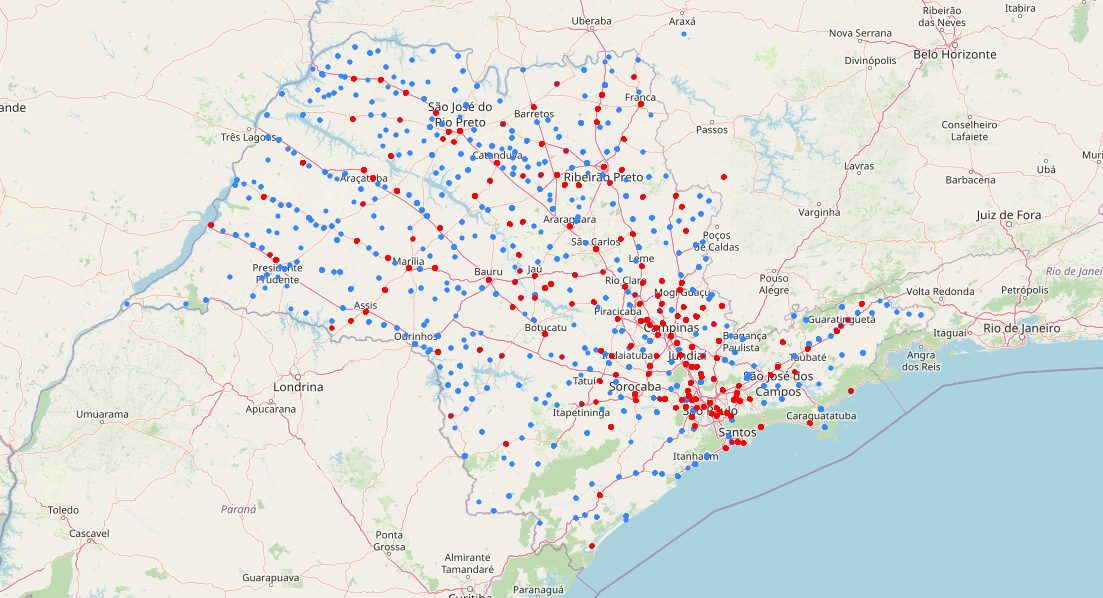

Precisamos agora calcular a distância percorrida entre o cliente e o vendedor com base na latitude e longitude de ambos. Para isso, usaremos a biblioteca da equação de ```Haversine```

Calculando a distância percorrida entre o cliente e o vendedor com a biblioteca Haversine

In [ ]:
new_dfsp.loc[:,['lon_seller','lat_seller','lon_customer','lat_customer']].head()

,lon_seller,lat_seller,lon_customer,lat_customer
0,-46.448909,-23.669994,-46.633242,-23.57086
1,-46.448909,-23.669994,-46.633242,-23.57086
2,-46.448909,-23.669994,-46.633242,-23.57086
3,-46.448909,-23.669994,-46.633242,-23.57086
4,-46.448909,-23.669994,-46.633242,-23.57086


In [ ]:
seller = []
for i in zip(new_dfsp['lon_seller'],new_dfsp['lat_seller']):
  seller.append(i)

customer = []
for i in zip(new_dfsp['lon_customer'],new_dfsp['lat_customer']):
  customer.append(i)

In [ ]:
# Verificando A quantidade de valores em Seller e Customer
print('Total de cordenadas de Vededores disponível:',len(seller))
print('Total de cordenadas de Clientes disponível:',len(customer))

Total de cordenadas de Vededores disponível: 35376
Total de cordenadas de Clientes disponível: 35376


In [ ]:
distance = []
for i in range(0,35376):
  distance.append(haversine(seller[i],customer[i]))

In [ ]:
new_df1 = new_dfsp.assign(dist = distance)

In [ ]:
new_df1.loc[:,['lon_seller','lat_seller','lon_customer','lat_customer','dist']].head()

,lon_seller,lat_seller,lon_customer,lat_customer,dist
0,-46.448909,-23.669994,-46.633242,-23.57086,21.854338
1,-46.448909,-23.669994,-46.633242,-23.57086,21.854338
2,-46.448909,-23.669994,-46.633242,-23.57086,21.854338
3,-46.448909,-23.669994,-46.633242,-23.57086,21.854338
4,-46.448909,-23.669994,-46.633242,-23.57086,21.854338


In [ ]:
new_df1.reset_index(drop=True, inplace=True)

# 4. Analisando as ditâncias.

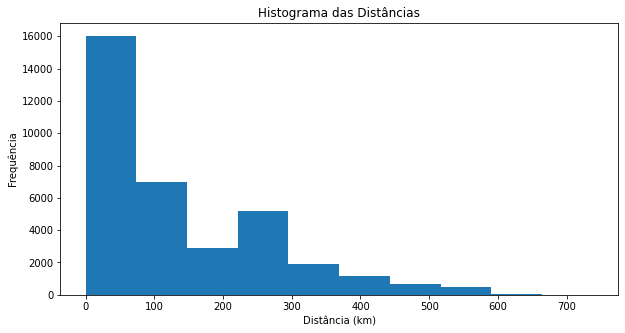

In [ ]:
# Histograma das distâncias
fig, ax = plt.subplots(figsize = (10,5))
new_df1['dist'].plot(kind="hist", ax = ax);
ax.set_title('Histograma das Distâncias')
ax.set_xlabel('Distância (km)')
ax.set_ylabel('Frequência')
plt.show()

É possível notar que a maior parte das vendas ocorre em um perimetro de até 100km

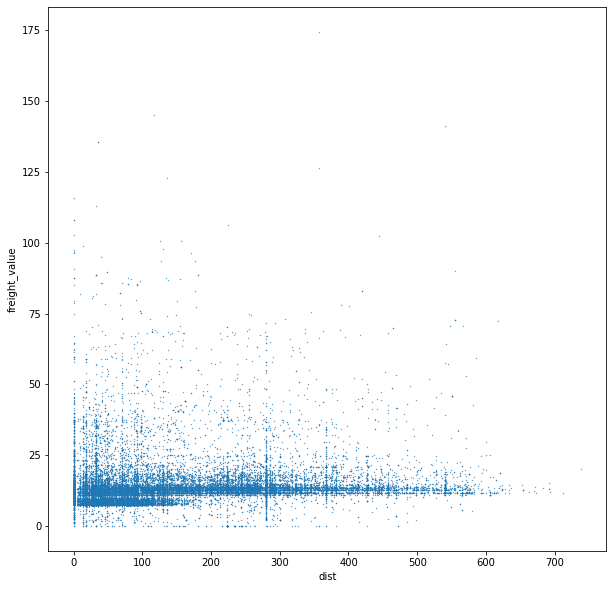

In [ ]:
new_df1.plot.scatter(x='dist', y='freight_value', s=0.1, figsize=(10,10))

plt.show()

Atráves do gráfico de dispersão é possível notar que os valores do frete não sofrem uma variação significativa a medida que a distância aumenta.

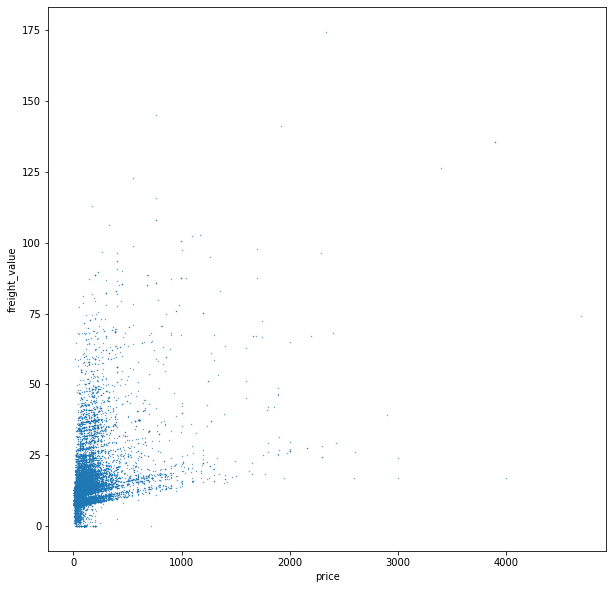

In [ ]:
new_df1.plot.scatter(x='price', y='freight_value', s=0.1, figsize=(10,10))

plt.show()

In [ ]:
drone

,velocidade,peso_suportado_g,distancia_max_km
modelo,,,
DRARGO-1,100,4100,100
DRARGO-2,100,3700,200
DRARGO-3,100,3400,300
DRARGO-4,100,3000,400
DRARGO-5,100,1700,700


In [ ]:
p1 = drone.at['DRARGO-1','peso_suportado_g']
p2 = drone.at['DRARGO-2','peso_suportado_g']
p3 = drone.at['DRARGO-3','peso_suportado_g']
p4 = drone.at['DRARGO-4','peso_suportado_g']
p5 = drone.at['DRARGO-5','peso_suportado_g']

d1 = drone.at['DRARGO-1','distancia_max_km']
d2 = drone.at['DRARGO-2','distancia_max_km']
d3 = drone.at['DRARGO-3','distancia_max_km']
d4 = drone.at['DRARGO-4','distancia_max_km']
d5 = drone.at['DRARGO-5','distancia_max_km']

In [ ]:
#Criando as condiçoes para classificar qual drone fará a viagem
condition = [
((new_df1['product_weight_g'] < p1) & (new_df1['dist'] < d1)),
((new_df1['product_weight_g'] < p2) & (new_df1['dist'] < d2)),
((new_df1['product_weight_g'] < p3) & (new_df1['dist'] < d3)),
((new_df1['product_weight_g'] < p4) & (new_df1['dist'] < d4)),
((new_df1['product_weight_g'] < p5) & (new_df1['dist'] < d5))
]

model = ['DRARGO-1','DRARGO-2','DRARGO-3','DRARGO-4','DRARGO-5']

In [ ]:
#criando a coluna de classificação de Modelo
new_df1['drone'] = np.select(condition, model, default="sem_modelo_diponivel")

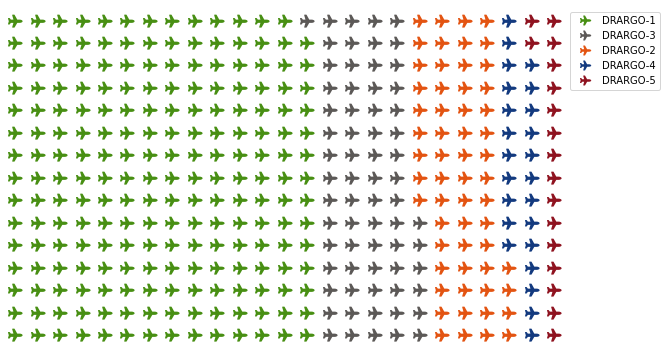

In [ ]:
# plotar gráfico de waffle
fig = plt.figure(
                FigureClass=Waffle,
                rows=15,
                columns=25,
                colors=("#488f13", "#5c5957", "#e35412", '#133a7f' , "#8f1320" ),
                values={'DRARGO-1':16858, 'DRARGO-3':5402, 'DRARGO-2': 4716, 'DRARGO-4': 1951, 'DRARGO-5':1383}, 
                icons='plane', 
                icon_size=13,
                legend={'loc': 'upper left', 'bbox_to_anchor': (1,1)},
                icon_legend=True,
                figsize=(10,20)
                )
fig.set_tight_layout(False)
plt.show();

## Maior área de trafego


In [158]:
# Crriando um Heatmap onde ocorreu maio quantidade de compras e consequentemente maior tráfego aéreo de Drones
locais = []
heatmap = folium.Map(location=[-21.9915585,-46.9686072], zoom_start=7)

for index, linha in new_dfsp.iterrows():
  temp = [new_dfsp['lat_customer'].values,new_dfsp['lon_customer'].values]
  locais.append(temp)

locais = new_dfsp[['lat_customer','lon_customer']].values.tolist()
HeatMap(locais, radius=20, min_opacity=0.4).add_to(heatmap)

heatmap

Como era esperado, as cidades de São Paulo e Campinas apresentaram um fluxo maior. Além dessas, é possível identificar Santos, Ribeirão Preto e Sorocaba, por exemplo.

## Calculado o Tempo

In [ ]:
Td = 0
Td_residual = 0
for i in range(0,new_df1.shape[0]):
    T = new_df1['order_delivered_customer_date'][i] - new_df1['order_delivered_carrier_date'][i]
    Td = Td + T.days
    Td_residual = Td_residual + ((T.seconds)/3600)/24

T_Total = (Td + Td_residual)*24

In [ ]:
print(f'Foram gastos {T_Total/24 :.8} dias para transportar todos os produtos \nUm total de {T_Total :.9} Horas')

Foram gastos 167102.12 dias para transportar todos os produtos 
Um total de 4010450.89 Horas


Utilizando a função da velocidade média Vm = Distância(km)/Tempo(h) calcularemos o tempo gasto dessas viagens se elas fossem feitas por um DRARGO. Estimando que a velocidade fosse 80km/h teriamos o seguinte resultado:

In [ ]:
T_Drone = new_df1['dist'].apply(lambda x: x/80)
print(f'Total em horas gastos pelos DRARGOS: {T_Drone.sum() :.8}h')

Total em horas gastos pelos DRARGOS: 59512.042h


Todavia, sabendo que há inumeros contratempos na execução. Cita-se, como exemplo, o carregamento da mercadoria, os corredores aéreos não retilíneos, o possível tráfego aéreo de drones que existirá... Desta forma, optamos por aumentar esse tempo em 3x mais.  

In [ ]:
tempo_drone = T_Drone.sum() * 3
print(f'Total em horas gastos pelos DRARGOS: {tempo_drone.sum() :.8}h')

Total em horas gastos pelos DRARGOS: 178536.13h


In [ ]:
tt = ['T empo Transporte Convencional','T empo Drone']
val = [T_Total,tempo_drone]

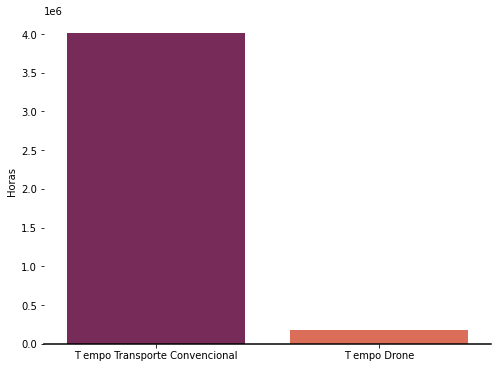

In [ ]:
f, (ax1) = plt.subplots(1, figsize=(8, 6), sharex=True)
x = np.array(tt)
y1 = val
sns.barplot(x=x, y=y1, palette="rocket", ax=ax1)
sns.despine(bottom = True, left = True)
#plt.tick_params(axis ='y', labelsize=2, length = 0) 
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Horas")
plt.show()

In [ ]:
print(f"Isso representa uma redução de {(1-(tempo_drone/T_Total))*100 :.4}% do Tempo utilizando os métodos convencionais")

Isso representa uma redução de 95.55% do Tempo utilizando os métodos convencionais


## Modelo Que Mais Voou

Apesar do modelo DRARGO-1 ser o modelo mais utilizado por viagens curtas, como mostra o grafico de Waffle, o DRARGO-3 passará mais tempo voando. Aumentar a resistência desse modelo seria uma boa medida a ser adotada.

In [ ]:
#Agrupando valores com base no modelo do drone e aplicando o somatório
df_drone_sum = new_df1[new_df1['drone'] !='sem_modelo_diponivel'].groupby('drone').sum()
df_drone_sum

,order_item_id,price,freight_value,payment_sequential,payment_installments,payment_value,review_score,product_name_lenght,product_description_lenght,product_photos_qty,...,product_length_cm,product_height_cm,product_width_cm,customer_zip_code_prefix,seller_zip_code_prefix,lat_customer,lon_customer,lat_seller,lon_seller,dist
drone,,,,,,,,,,,,,,,,,,,,,
DRARGO-1,20562.0,1391515.76,169172.36,18088.0,38693.0,1941656.37,71194.0,816228.0,12841114.0,40349.0,...,443388.0,226390.0,337575.0,129680382,123949285.0,-394890.540019,-787883.568713,-394979.551317,-787653.624341,5.926239e+05
DRARGO-2,5599.0,402483.64,57250.42,4963.0,12398.0,567874.93,19959.0,234954.0,3333912.0,9650.0,...,131225.0,59896.0,103274.0,55686543,54535194.0,-108073.371202,-222323.577858,-107502.201210,-223428.054646,6.636024e+05
DRARGO-3,6712.0,475834.99,71777.58,6395.0,15680.0,711535.84,21947.0,267416.0,3489483.0,9319.0,...,165398.0,66904.0,129712.0,50236301,71777933.0,-124513.516550,-254641.771229,-118742.766304,-260068.215065,1.373727e+06
DRARGO-4,2403.0,160357.72,26835.47,2050.0,5259.0,250548.16,8113.0,100261.0,1157391.0,3934.0,...,57426.0,28539.0,46864.0,23578922,24614144.0,-44343.990680,-93174.301018,-43141.571597,-94129.133698,6.771754e+05
DRARGO-5,1806.0,91313.35,17909.13,1705.0,3457.0,161151.61,5786.0,69045.0,1049362.0,3066.0,...,36598.0,18352.0,27207.0,17793449,16826387.0,-31041.416270,-67236.184673,-31060.228899,-67170.995377,6.732357e+05


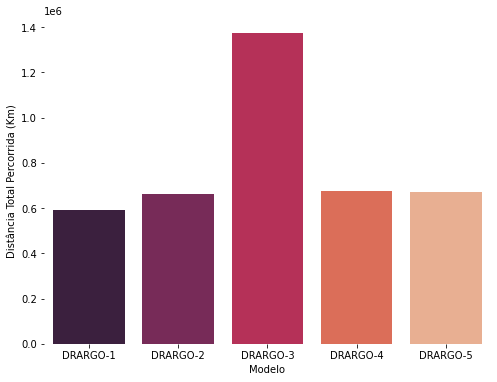

In [135]:
f, (ax3) = plt.subplots(1, figsize=(8, 6), sharex=True)
x3 = df_drone_sum.index
y3 = df_drone_sum['dist']
sns.barplot(x=x3, y=y3, palette="rocket", ax=ax3)
sns.despine(bottom = True, left = True)
#plt.tick_params(axis ='y', labelsize=2, length = 0) 
ax1.axhline(0, color="k", clip_on=False)
ax3.set_ylabel("Distância Total Percorrida (Km)")
ax3.set_xlabel("Modelo")
plt.show()